## 라이브러리와 파일 불러오기

In [51]:
import os
import pandas as pd
import numpy as np
from glob import glob

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

# Visualisation libraries
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import chart_studio.plotly as py
import plotly.figure_factory as ff
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# Pytorch
# import torch

# Transformers
# from transformers import BertTokenizer

In [12]:
data = glob('data/tweet-sentiment-extraction/*.csv')
data

['data/tweet-sentiment-extraction/test.csv',
 'data/tweet-sentiment-extraction/train.csv',
 'data/tweet-sentiment-extraction/sample_submission.csv']

In [196]:
train = pd.read_csv(data[1])
test = pd.read_csv(data[0])

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (27481, 4)
Testing data shape:  (3534, 3)


## 데이터 살펴보기

In [20]:
display(train.head())
display(test.head())

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


## EDA

### 결측치 확인 & 제거

In [21]:
train.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [22]:
test.isnull().sum()

textID       0
text         0
sentiment    0
dtype: int64

In [23]:
# how{‘any’, ‘all’}, default ‘any’
# Determine if row or column is removed from DataFrame, when we have at least one NA or all NA.
# ‘any’ : If any NA values are present, drop that row or column.
# ‘all’ : If all values are NA, drop that row or column.
train.dropna(axis=0, how='any', inplace=True)

## 데이터 샘플 확인

In [27]:
# Positive tweet
print("Positive Tweet example :",train[train['sentiment']=='positive']['text'].values[0])
#negative_text
print("Negative Tweet example :",train[train['sentiment']=='negative']['text'].values[0])
#neutral_text
print("Neutral tweet example  :",train[train['sentiment']=='neutral']['text'].values[0])

Positive Tweet example : 2am feedings for the baby are fun when he is all smiles and coos
Negative Tweet example :  Sooo SAD I will miss you here in San Diego!!!
Neutral tweet example  :  I`d have responded, if I were going


In [29]:
# 1.5 : 1: 1
train['sentiment'].value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [30]:
# value_counts() 비율료 확인
train['sentiment'].value_counts(normalize=True)

neutral     0.404549
positive    0.312300
negative    0.283151
Name: sentiment, dtype: float64

## 시각화

In [37]:
train['sentiment'].value_counts(normalize=True).iplot(kind='bar',
                                                      yTitle='Percentage', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='red',
                                                      theme='pearl',
                                                      bargap=0.6,
                                                      gridcolor='white',
                                                      title='Distribution of Sentiment column in the training set')

In [38]:
test['sentiment'].value_counts(normalize=True).iplot(kind='bar',
                                                      yTitle='Percentage', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='red',
                                                      theme='pearl',
                                                      bargap=0.6,
                                                      gridcolor='white',
                                                      title='Distribution  of Sentiment column in the test set')

## 텍스트 데이터 전처리

In [299]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''

    # 모든 텍스트 소문자로 변환
    text = text.lower()

    # .*? : 개행 문자(\n)를 제외한 모든 문자가 0부터 무한대로 반복되는 것 매치
    # 대괄호로 감싸져 있는 모든 문자를 대괄호와 함께 제거
    text = re.sub('\[.*?\]', '', text)

    # 링크 제거
    # \S : 공백 문자가 아닌 것과 매치, "|" : or 
    # \S+|www : 공백이 아닌 모든 문자가 1번이상 있거나 www로 시작하거나
    text = re.sub('https?://\S+|www\.\S+', '', text)

    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)

    # \w : 문자, 숫자, "_" 매치 [A-Za-z0-9_]
    # \d : 숫자와 매치 [0-9]
    text = re.sub('\w*\d\w*', '', text)
    return text

### 정규표현식 예시

In [200]:
temp = "!@#$[여기를 사라지게 해볼게]%^&*()"
temp

'!@#$[여기를 사라지게 해볼게]%^&*()'

In [201]:
re.sub('\[.*?\]', '', temp)

'!@#$%^&*()'

In [202]:
temp = "이건 안사라짐 https://www.naver.com 이건 안사라짐"
temp

'이건 안사라짐 https://www.naver.com 이건 안사라짐'

In [203]:
re.sub('https?://\S+|www\.\S+', '', temp)

'이건 안사라짐  이건 안사라짐'

In [204]:
temp = "이건 안사라짐 https://naver.com 이건 안사라짐"
temp

'이건 안사라짐 https://naver.com 이건 안사라짐'

In [205]:
re.sub('https?://\S+|www\.\S+', '', temp)

'이건 안사라짐  이건 안사라짐'

In [291]:
def clean_text1(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    return text

def clean_text2(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    return text

def clean_text3(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    return text

def clean_text4(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

def clean_text5(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    return text

def clean_text6(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [292]:
test1 = train['text'].astype(str).apply(lambda x: x.lower())
test1

0                      i`d have responded, if i were going
1            sooo sad i will miss you here in san diego!!!
2                                my boss is bullying me...
3                           what interview! leave me alone
4         sons of ****, why couldn`t they put them on t...
                               ...                        
27476     wish we could come see u on denver  husband l...
27477     i`ve wondered about rake to.  the client has ...
27478     yay good for both of you. enjoy the break - y...
27479                           but it was worth it  ****.
27480       all this flirting going on - the atg smiles...
Name: text, Length: 27481, dtype: object

In [293]:
test2 = test1.astype(str).apply(lambda x: clean_text1(x))
test2

0                      i`d have responded, if i were going
1            sooo sad i will miss you here in san diego!!!
2                                my boss is bullying me...
3                           what interview! leave me alone
4         sons of ****, why couldn`t they put them on t...
                               ...                        
27476     wish we could come see u on denver  husband l...
27477     i`ve wondered about rake to.  the client has ...
27478     yay good for both of you. enjoy the break - y...
27479                           but it was worth it  ****.
27480       all this flirting going on - the atg smiles...
Name: text, Length: 27481, dtype: object

In [294]:
# True : 전처리 발생 X
# False : 전처리 발생
test_df = pd.DataFrame({'test1': test1, 'test2': test2, 'same12': test1==test2})
test_df

,test1,test2,same12
0,"i`d have responded, if i were going","i`d have responded, if i were going",True
1,sooo sad i will miss you here in san diego!!!,sooo sad i will miss you here in san diego!!!,True
2,my boss is bullying me...,my boss is bullying me...,True
3,what interview! leave me alone,what interview! leave me alone,True
4,"sons of ****, why couldn`t they put them on t...","sons of ****, why couldn`t they put them on t...",True
...,...,...,...
27476,wish we could come see u on denver husband l...,wish we could come see u on denver husband l...,True
27477,i`ve wondered about rake to. the client has ...,i`ve wondered about rake to. the client has ...,True
27478,yay good for both of you. enjoy the break - y...,yay good for both of you. enjoy the break - y...,True
27479,but it was worth it ****.,but it was worth it ****.,True


In [295]:
test3 = test2.astype(str).apply(lambda x: clean_text2(x))
test4 = test3.astype(str).apply(lambda x: clean_text3(x))
test5 = test4.astype(str).apply(lambda x: clean_text4(x))
test6 = test5.astype(str).apply(lambda x: clean_text5(x))
test7 = test6.astype(str).apply(lambda x: clean_text6(x))

In [296]:
test_df = pd.DataFrame({'함수0': test1, '함수1': test2, '함수2': test3, '함수3': test4, '함수4': test5, '함수5': test6, '함수6': test7})
test_df

,함수0,함수1,함수2,함수3,함수4,함수5,함수6
0,"i`d have responded, if i were going","i`d have responded, if i were going","i`d have responded, if i were going","i`d have responded, if i were going",id have responded if i were going,id have responded if i were going,id have responded if i were going
1,sooo sad i will miss you here in san diego!!!,sooo sad i will miss you here in san diego!!!,sooo sad i will miss you here in san diego!!!,sooo sad i will miss you here in san diego!!!,sooo sad i will miss you here in san diego,sooo sad i will miss you here in san diego,sooo sad i will miss you here in san diego
2,my boss is bullying me...,my boss is bullying me...,my boss is bullying me...,my boss is bullying me...,my boss is bullying me,my boss is bullying me,my boss is bullying me
3,what interview! leave me alone,what interview! leave me alone,what interview! leave me alone,what interview! leave me alone,what interview leave me alone,what interview leave me alone,what interview leave me alone
4,"sons of ****, why couldn`t they put them on t...","sons of ****, why couldn`t they put them on t...","sons of ****, why couldn`t they put them on t...","sons of ****, why couldn`t they put them on t...",sons of why couldnt they put them on the rel...,sons of why couldnt they put them on the rel...,sons of why couldnt they put them on the rel...
...,...,...,...,...,...,...,...
27476,wish we could come see u on denver husband l...,wish we could come see u on denver husband l...,wish we could come see u on denver husband l...,wish we could come see u on denver husband l...,wish we could come see u on denver husband l...,wish we could come see u on denver husband l...,wish we could come see u on denver husband l...
27477,i`ve wondered about rake to. the client has ...,i`ve wondered about rake to. the client has ...,i`ve wondered about rake to. the client has ...,i`ve wondered about rake to. the client has ...,ive wondered about rake to the client has ma...,ive wondered about rake to the client has ma...,ive wondered about rake to the client has ma...
27478,yay good for both of you. enjoy the break - y...,yay good for both of you. enjoy the break - y...,yay good for both of you. enjoy the break - y...,yay good for both of you. enjoy the break - y...,yay good for both of you enjoy the break you...,yay good for both of you enjoy the break you...,yay good for both of you enjoy the break you...
27479,but it was worth it ****.,but it was worth it ****.,but it was worth it ****.,but it was worth it ****.,but it was worth it,but it was worth it,but it was worth it


In [297]:
def temp_func(a, b):
    condition = test_df[a] == test_df[b]
    res = test_df.loc[~condition, [a, b]]
    return res

In [298]:
function_dict = {
    1: "re.sub('\[.*?\]', '', text)", 
    2: "re.sub('https?://\S+|www\.\S+', '', text)", 
    3: "re.sub('<.*?>+', '', text)", 
    4: "re.sub('[%s]' % re.escape(string.punctuation), '', text)", 
    5: "re.sub('\\n', '', text)",
    6: "re.sub('\w*\d\w*', '', text)"}

for i in range(6):
    print(f"함수 {i + 1} 가(이) 반영된 결과물", "          " , function_dict[i + 1])
    display(temp_func(f'함수{i}', f'함수{i+1}'))
    print("-" * 100)

함수 1 가(이) 반영된 결과물            re.sub('\[.*?\]', '', text)


,함수0,함수1
410,[-o] i wish the birthday massacre would come t...,i wish the birthday massacre would come to au...
1284,? american pie forever. i`m watching it right ...,? american pie forever. i`m watching it right ...
2194,[ i`m not sure what you mean by 'blowin this j...,rb lol lol good one...... ? http://blip.fm/~...
3173,night night twitter world. [still cant believe...,night night twitter world.
3833,"'phlegmily green house...' that was clever, b...","'phlegmily green house...' that was clever, b..."
4601,yesterday was fun.. 1st concert of the year [i...,yesterday was fun.. 1st concert of the year .....
4661,[stapler haiku] whar a night! woo hoo! yeah! /...,whar a night! woo hoo! yeah! / a beautiful ni...
4980,last reply a scholar in us homeland security...,last reply a scholar in us homeland security...
6399,*[ it`s time for tscc! ],*
7524,new blog post: [blog] auto insuran...: i just ...,new blog post: auto insuran...: i just found ...


----------------------------------------------------------------------------------------------------
함수 2 가(이) 반영된 결과물            re.sub('https?://\S+|www\.\S+', '', text)


,함수1,함수2
5,http://www.dothebouncy.com/smf - some shameles...,- some shameless plugging for the best ranger...
17,i`ve been sick for the past few days and thus...,i`ve been sick for the past few days and thus...
35,"thats it, its the end. tears for fears vs eric...","thats it, its the end. tears for fears vs eric..."
50,then you should check out http://twittersucks...,then you should check out and connect with o...
57,will be back later. http://plurk.com/p/rp3k7,will be back later.
...,...,...
27374,"says finally, im home. http://plurk.com/p/rr121","says finally, im home."
27384,this is a much better tool than some i have co...,this is a much better tool than some i have co...
27386,#vwll2009 would one of the vwllers want to add...,#vwll2009 would one of the vwllers want to add...
27463,like drew said 'give tc a chance' we will mis...,like drew said 'give tc a chance' we will mis...


----------------------------------------------------------------------------------------------------
함수 3 가(이) 반영된 결과물            re.sub('<.*?>+', '', text)


,함수2,함수3
1783,on jacksonville beach walking in the cold ****...,on jacksonville beach walking in the cold ****...
9224,allergies suck ducks nuts. <=====8=====>,allergies suck ducks nuts.
12250,whoishonorsociety <never wear your pajama pant...,whoishonorsociety
15294,good nite everybody! <:baby boy:>,good nite everybody!
17357,) no more chemistry!!! i`m gonna choose englis...,) no more chemistry!!! i`m gonna choose englis...
18683,welll my folkiesss(; im offf to dream land;wor...,welll my folkiesss(; im offf to dream land;wor...
19888,"i like fridays generally, but class is ext...","i like fridays generally, but class is ext..."
21153,i never get them and the hubby is due in next...,i never get them and the hubby is due in next...
23645,fireworks @ kboom concert... second best i`ve ...,fireworks @ kboom concert... second best i`ve ...
25221,"oh, ouch. that hurt. **** washing machine is ...","oh, ouch. that hurt. **** washing machine is ..."


----------------------------------------------------------------------------------------------------
함수 4 가(이) 반영된 결과물            re.sub('[%s]' % re.escape(string.punctuation), '', text)


,함수3,함수4
0,"i`d have responded, if i were going",id have responded if i were going
1,sooo sad i will miss you here in san diego!!!,sooo sad i will miss you here in san diego
2,my boss is bullying me...,my boss is bullying me
3,what interview! leave me alone,what interview leave me alone
4,"sons of ****, why couldn`t they put them on t...",sons of why couldnt they put them on the rel...
...,...,...
27476,wish we could come see u on denver husband l...,wish we could come see u on denver husband l...
27477,i`ve wondered about rake to. the client has ...,ive wondered about rake to the client has ma...
27478,yay good for both of you. enjoy the break - y...,yay good for both of you enjoy the break you...
27479,but it was worth it ****.,but it was worth it


----------------------------------------------------------------------------------------------------
함수 5 가(이) 반영된 결과물            re.sub('\n', '', text)


,함수4,함수5


----------------------------------------------------------------------------------------------------
함수 6 가(이) 반영된 결과물            re.sub('\w*\d\w*', '', text)


,함수5,함수6
6,2am feedings for the baby are fun when he is a...,feedings for the baby are fun when he is all ...
14,test test from the lg env2,test test from the lg
20,oh marly im so sorry i hope you find her soo...,oh marly im so sorry i hope you find her soon
23,gotta restart my computer i thought win7 was ...,gotta restart my computer i thought was supp...
24,see wat i mean bout foll0w friidays its called...,see wat i mean bout friidays its called lose ...
...,...,...
27456,i wanna leave work already not feelin it 2day,i wanna leave work already not feelin it
27462,just back from bingo wfamily i won over 1100 ...,just back from bingo wfamily i won over fun ...
27464,rec gametrying not to crythe pain is to muchi ...,rec gametrying not to crythe pain is to muchi ...
27466,naw it was pretty tame only 1 guy in costume ...,naw it was pretty tame only guy in costume a...


----------------------------------------------------------------------------------------------------


## 텍스트 전처리

In [300]:
def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    # 토크나이저 선언
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

    # 텍스트 전처리
    nopunc = clean_text(text)

    # 전처리된 텍스트를 토크나이저 행
    tokenized_text = tokenizer.tokenize(nopunc)
    #remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]

    # 결과물을 공백 하나로 결합
    combined_text = ' '.join(tokenized_text)
    return combined_text

In [215]:
train['text_clean'] = train['text'].apply(str).apply(lambda x: text_preprocessing(x))
test['text_clean'] = test['text'].apply(str).apply(lambda x: text_preprocessing(x))

In [216]:
train.head()

,textID,text,selected_text,sentiment,text_clean
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id have responded if i were going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad i will miss you here in san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of why couldnt they put them on the relea...


## Analyzing Text Statistics

In [217]:
# 전처리된 텍스트의 길이
train['text_len'] = train['text_clean'].astype(str).apply(len)

# 전처리된 텍스트 단어의 개수
train['text_word_count'] = train['text_clean'].apply(lambda x: len(str(x).split()))

In [218]:
train.head(3)

,textID,text,selected_text,sentiment,text_clean,text_len,text_word_count
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id have responded if i were going,33,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad i will miss you here in san diego,42,10
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me,22,5


In [219]:
pos = train[train['sentiment']=='positive']
neg = train[train['sentiment']=='negative']
neutral = train[train['sentiment']=='neutral']

### 텍스트 길이 히스토그램

In [228]:
pos['text_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    color='red',
    yTitle='count',
    title='Positive Text Length Distribution')

neg['text_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    color='green',
    yTitle='count',
    title='Negative Text Length Distribution')

neutral['text_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    yTitle='count',
    title='Neutral Text Length Distribution')

### 텍스트의 길이 boxplot

In [229]:
trace0 = go.Box(
    y=pos['text_len'],
    name = 'Positive Text',
    marker = dict(
        color = 'red',
    )
)

trace1 = go.Box(
    y=neg['text_len'],
    name = 'Negative Text',
    marker = dict(
        color = 'green',
    )
)

trace2 = go.Box(
    y=neutral['text_len'],
    name = 'Neutral Text',
    marker = dict(
        color = 'orange',
    )
)
data = [trace0, trace1, trace2]
layout = go.Layout(
    title = "Length of the text"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Length of the text of different polarities")

### 단어의 개수 히스토그램

In [230]:
pos['text_word_count'].iplot(
    kind='hist',
    bins=50,
    xTitle='text length',
    linecolor='black',
    color='red',
    yTitle='count',
    title='Positive Text word count')

neg['text_word_count'].iplot(
    kind='hist',
    bins=50,
    xTitle='text length',
    linecolor='black',
    color='green',
    yTitle='count',
    title='Negative Text word count')

neutral['text_word_count'].iplot(
    kind='hist',
    bins=50,
    xTitle='text length',
    linecolor='black',
    yTitle='count',
    title='Neutral Text word count')

### 단어의 개수 boxplot

In [231]:
trace0 = go.Box(
    y=pos['text_word_count'],
    name = 'Positive Text',
    marker = dict(
        color = 'red',
    )
)

trace1 = go.Box(
    y=neg['text_word_count'],
    name = 'Negative Text',
    marker = dict(
        color = 'green',
    )
)

trace2 = go.Box(
    y=neutral['text_word_count'],
    name = 'Neutral Text',
    marker = dict(
        color = 'orange',
    )
)
data = [trace0, trace1, trace2]
layout = go.Layout(
    title = "word count of the text"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "word count of the text of different polarities")

### 단어 빈도수 시각화

In [250]:
# 행렬 인덱싱 방법
l = np.matrix([[0, 1, 2, 3, 4, 5, 6],
               [0, 1, 2, 3, 4, 5, 6]])
print(l[0, 4])
print(l[1, 3])

4
3


In [251]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    # fit_transform
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)

    # 텍스트별 단어 빈도수 합계, 2차원 매트릭스
    sum_words = bag_of_words.sum(axis=0) 

    # 단어장에서 단어와 그에 맞는 index를 가져옴
    # index를 활용하여 (단어, 단어의 개수) 저장
    # i am king king king king
    # ex_sum_words = [[1, 1, 4]]
    # [("i", 0), ("am", 1), ("king", 2)]
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    # 단어의 개수를 기준으로 내림차순 정렬
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    # 정해진 개수만큼 반환
    return words_freq[:n]

In [263]:
df1 = pd.DataFrame(pos_unigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='red', title='Top 20 Unigrams in positve text',orientation='h')

[plotly layout 공식문서](https://plotly.com/python/reference/layout/)

In [270]:
# Top20 단어 반환
pos_unigrams = get_top_n_words(pos['text_clean'],20)
neg_unigrams = get_top_n_words(neg['text_clean'],20)
neutral_unigrams = get_top_n_words(neutral['text_clean'],20)

layout1 = cufflinks.Layout(height=700, width=1300, title='Top 20 Unigrams in positive text')
layout2 = cufflinks.Layout(height=700, width=1300, title='Top 20 Unigrams in negative text')
layout3 = cufflinks.Layout(height=700, width=1300, title='Top 20 Unigrams in neurtal text')

# df1.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
#     kind='bar', yTitle='Count', linecolor='black',color='red', title='Top 20 Unigrams in positve text',orientation='h', layout=layout)

df1 = pd.DataFrame(pos_unigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='red', orientation='h', layout=layout1)

df2 = pd.DataFrame(neg_unigrams, columns = ['Text' , 'count'])
df2.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black', color='green', orientation='h', layout=layout2)

df3 = pd.DataFrame(neutral_unigrams, columns = ['Text' , 'count'])
df3.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black', orientation='h', layout=layout3)

### ngram_range

In [271]:
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [277]:
pos_bigrams = get_top_n_gram(pos['text_clean'],(2,2),20)
neg_bigrams = get_top_n_gram(neg['text_clean'],(2,2),20)
neutral_bigrams = get_top_n_gram(neutral['text_clean'],(2,2),20)


df1 = pd.DataFrame(pos_bigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='red', orientation='h', layout=layout1)

df2 = pd.DataFrame(neg_bigrams, columns = ['Text' , 'count'])
df2.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black', color='green', orientation='h', layout=layout2)

df3 = pd.DataFrame(neutral_bigrams, columns = ['Text' , 'count'])
df3.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black', orientation='h', layout=layout3)

## selected_text

In [279]:
positive_text = train[train['sentiment'] == 'positive']['selected_text']
negative_text = train[train['sentiment'] == 'negative']['selected_text']
neutral_text = train[train['sentiment'] == 'neutral']['selected_text']

In [288]:
# Positive text
print("Positive Text example :",positive_text.values[0])
#negative_text
print("Negative Tweet example :",negative_text.values[0])
#neutral_text
print("Neutral tweet example  :",neutral_text.values[0])

Positive Text example : fun
Negative Tweet example : Sooo SAD
Neutral tweet example  : I`d have responded, if I were going


In [301]:
positive_text_clean = positive_text.apply(lambda x: text_preprocessing(x))
negative_text_clean = negative_text.apply(lambda x: text_preprocessing(x))
neutral_text_clean = neutral_text.apply(lambda x: text_preprocessing(x))

AttributeError: 'float' object has no attribute 'lower'

## Wordclouds

NameError: name 'neutral_text_clean' is not defined

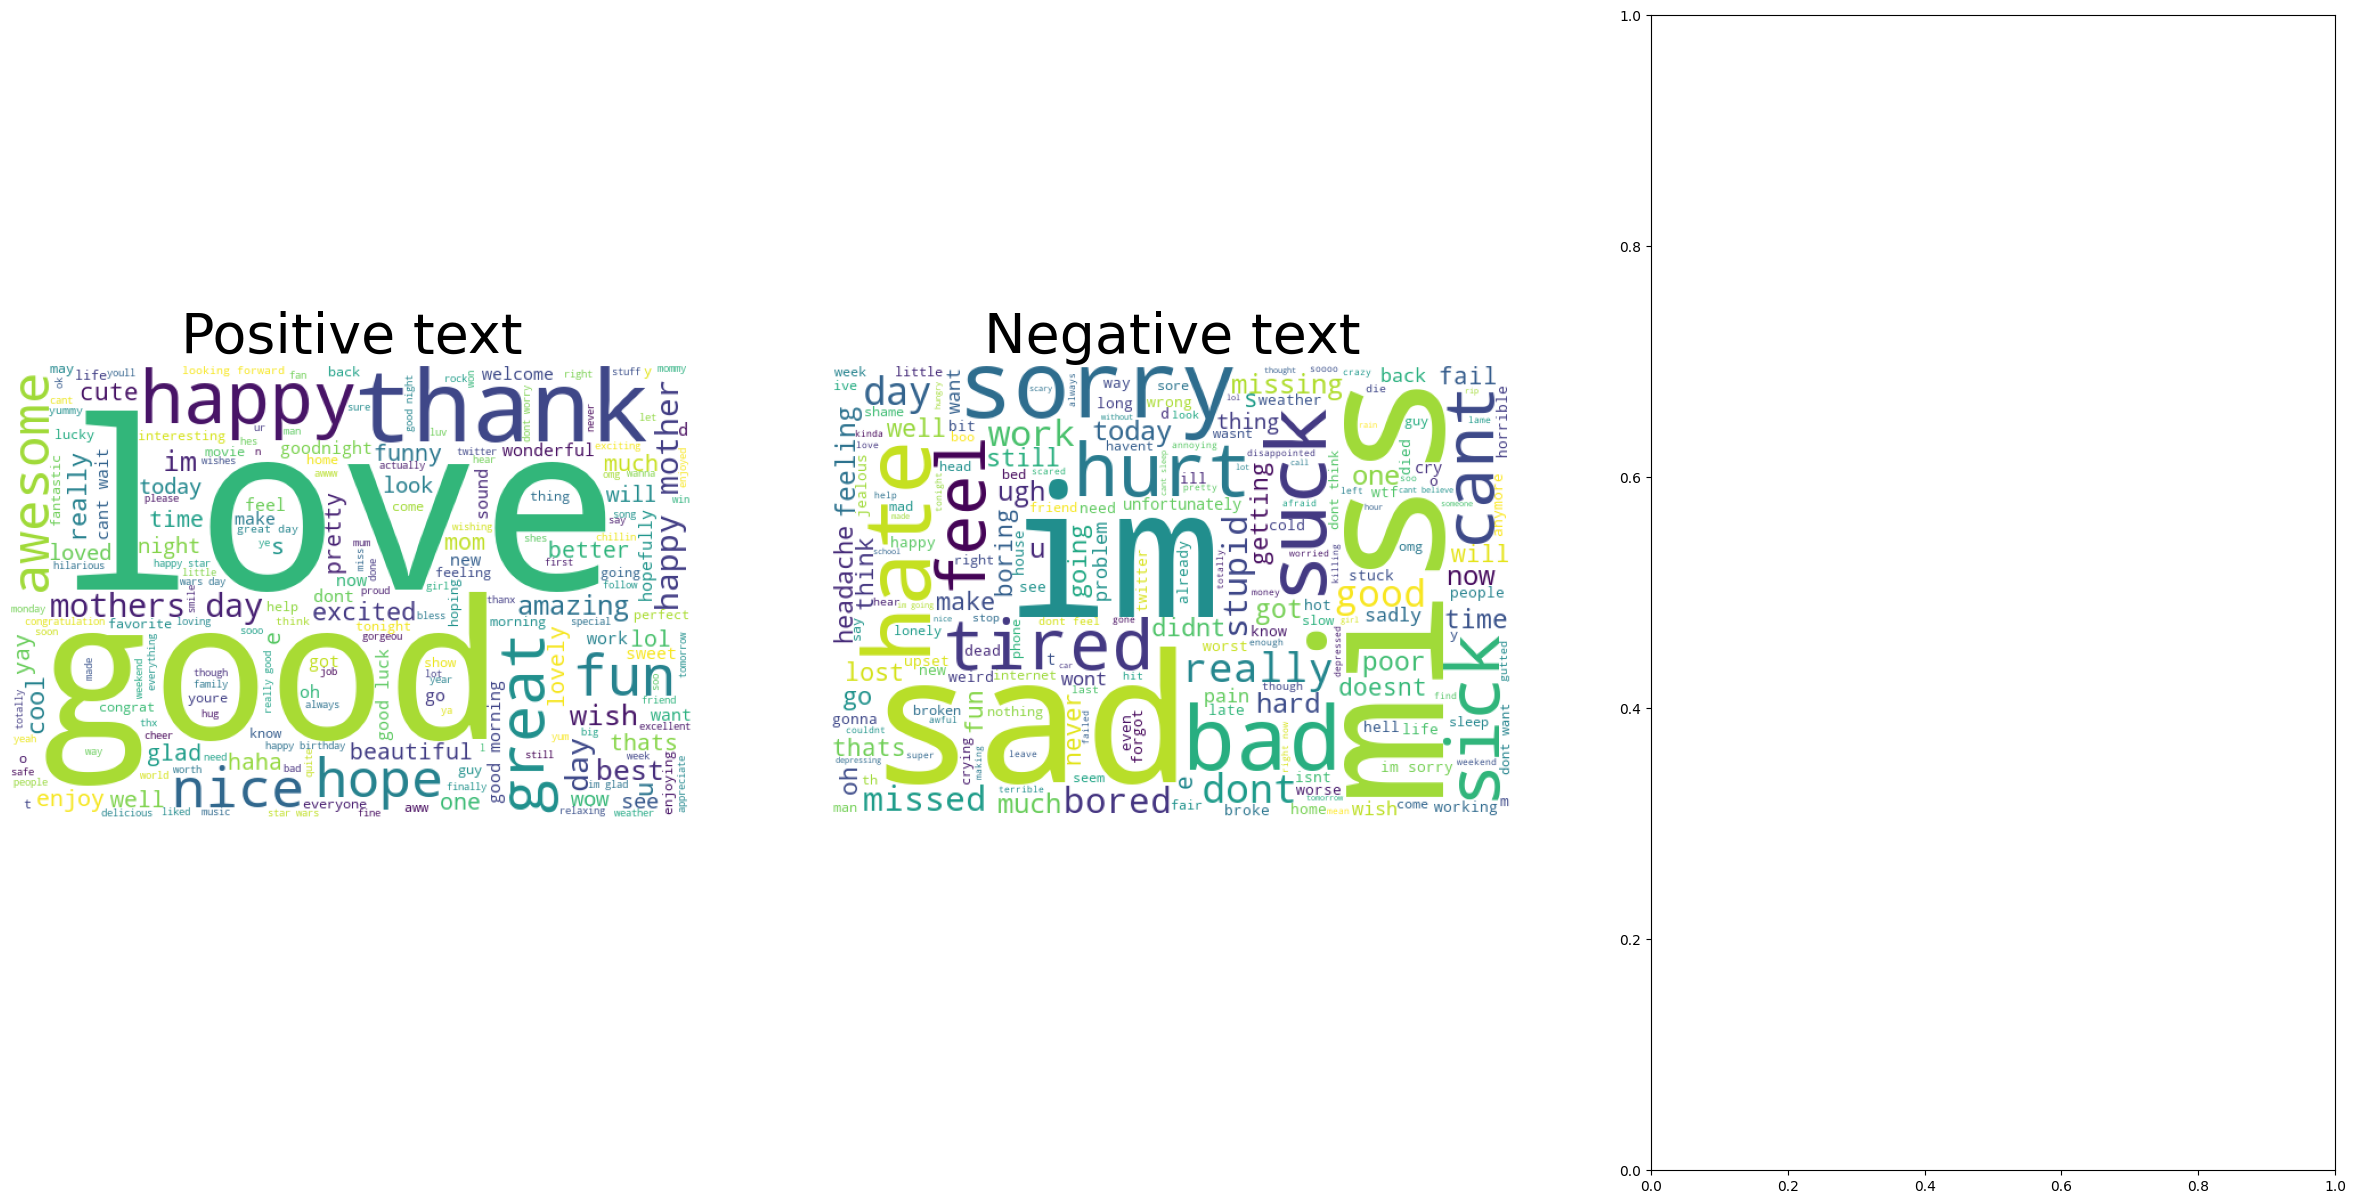

In [302]:
from wordcloud import WordCloud
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(positive_text_clean))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive text',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(negative_text_clean))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative text',fontsize=40);

wordcloud3 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(neutral_text_clean))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutral text',fontsize=40);